## swarm_1run

This is a simulation of an insect swarm that we're using to explore emergent behavior. Particularily, we're interested in defining swarming quantitatively so that we might be able to say something about how emergent behaviors are created.

The model is a random walk in 3D with various insect "behaviors" added as features in the model. There are multiple random walkers (insects) moving around in 3D space. The simulation will keep track of their 3D positions at each step in time. Each time the simulation is run, the system will behave differently at the individual level but statistically, on average, it should behave predictably. So in some ways, this is like a theorist's experiment that requires many data points to draw conclusions beyond a single event. 

This version, `swarm_1run`, only runs 1 time with an animation of the swarming event at the end. Another version of the code will handle multiple runs of the simulation to mimic taking many data points (as in an experiment).  

The features included are inspired by two different collective motion of swarming models: adaptive gravity by Gorbonos et. al and the Viscek model. The resulting model is a partially random walk where the insects are more likely to move in the direction of the center of mass of the swarm and in the vertical direction. 

https://arxiv.org/abs/1510.07259
https://arxiv.org/abs/cond-mat/0611743

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d #this is needed for scatter3D plotting
from scipy.stats import truncnorm # this is for the `com_weight` feature

In [2]:
rng = np.random.default_rng()

## SIMULATION GENERAL PARAMETERS
In this next section, we'll be setting the general parameters of the simulation: number of insects, size of initial container representing the insect's initial locations, number of time steps in each simulation, and the total number of simulations. We may want to add in other parameters to control the behaviors of the insects or modeling choices or to include other features like speed. For example, we may want to look at the differences in initial container geometery (cubic vs spherical vs elongated spherical). We'll start with a spherical container. 

Swarms range in size according to the insect, but since we'll focus on midges (a small type of non-biting fly) our swarms will typically range between 100 to 600 flies. We'll focus on midge swarms of this size because they have been studied by several groups (Oulette et al, Attanasi et al, Gorbonos et al). Often though, we we're changing or testing the model, you'll want to choose smaller size swarms to not generate too much data.

One of the additional features we've included in our model (beyond the random walk) is gravity. According to Gorbonos et al., swarms are elongated in the vertical direction so we'll need to turn this feature on with the `grav_on` parameter. More about this part of the model will be explained in the **MOVEMENT** part of the code.

https://iopscience.iop.org/article/10.1088/1367-2630/18/7/073042


In [3]:
n_insects = 100 # number of insects in simulation
n_steps = 100 # number of steps in time
r_init = 5 # radius of initial container
r_step = 1 # largest size of random step
n_dims = 3
grav_on = True # if True, gravity behavior is "on"
com_on = True # if True, center of mass (com) behavior is "on"
animate_on = True # if True, the animation section will run

## INITIAL POSITIONS

Before the insects can swarm, they need to be placed in space. Because the density of the insects is likely a feature involved in swarming, we'll place them initially in a container. The container could exist while the insects move (which means they can't move to a position outside of the container) or it could just serve as a control for the initial density of the collection of insects. For now, the insects can move out (and back in) of the initial container.

We may want to look at the differences in initial container geometery (cubic vs spherical) but for now we'll start with a spherical container of radius `r_init`. An insects position will start with a three randomly generated numbers, respresenting the insect's initial position ($r$, $\theta$, $\phi$). 

<img src= 3D_Spherical.png width="200" height="200">

That position will be the result of a random number between 0 and $r_{init}$ representing the insect's radius from the origin (0, 0, 0) of the container, another random number between 0 and $2 \pi$ representing the angle $\phi$ that the insect's position makes with the $x$-axis, and another random number between 0 and $\pi$ representing the angle $\theta$ that the insect's position makes with the $z$-axis. Once those numbers are generated, that information will be converted to `x`, `y`, and `z` positions using trigonometry. 

$ x_{init} = r_{init} \sin{\theta} \cos{\phi}$

$ y_{init} = r_{init} \sin{\theta} \sin{\phi}$

$ z_{init} = r_{init} \cos{\theta}$

Currently, we're not worrying about insects possibly occupying the same point in space, but we may need to worry about this or at least check into it at some point.

First, we'll generate a set of two random numbers representing the initial position (`r`, `theta`, `phi`) for each insect. Then that information is converted into `x`, `y`, and `z` coordinates for each insect (stored in 1D arrays named `x_init`, `y_init`, and `z_init`. 

In [4]:
rand_r_init = r_init*rng.random(n_insects)
rand_phi_init = 2*np.pi*rng.random(n_insects)
rand_theta_init = np.pi*rng.random(n_insects)
x_init, y_init, z_init = rand_r_init*np.sin(rand_theta_init)*np.cos(rand_phi_init), rand_r_init*np.sin(rand_theta_init)*np.sin(rand_phi_init), rand_r_init*np.cos(rand_theta_init)
insects_init = x_init, y_init, z_init

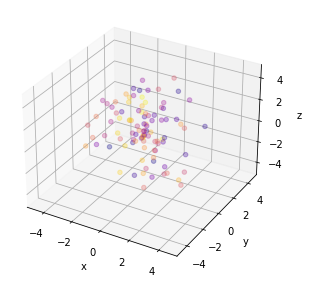

In [5]:
# initial scatter plot, each insect is represented by a different color

plt.rcParams["figure.figsize"] = [5.00, 4.00]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
colors = range(1, n_insects+1, 1) #this gives each insect a different color
ax.scatter3D(x_init, y_init, z_init, c = colors, cmap = 'plasma', alpha=0.3) 
ax.set(xlim=(-r_init, r_init), ylim=(-r_init, r_init), zlim = (-r_init, r_init))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## MOVEMENT

This block takes the insects from their initial positions and moves them randomly in space with extra weight in the z-direction to include the `adaptive_gravity` and `com_weight` features. The features are added by generating random numbers weighted to make movement in the z-direction (`adaptive gravity`) and/or the center of mass (`com_weight`) more likely. The weighting for `adaptive_gravity` uses a kludged together method that consists of dividing up space into quandrants and using normal distributions to achieve a truncated bimodal normal distribution. There is probably a better way to do this but I think this is sufficient for now. We may want to investigate a better way of doing this with a single probability distribution. 

This diagram shows the bimodal probability distribution used in the `adaptive_gravity` feature.

<img src= bimodal.png width="200" height="200">

The `com_weight` feature uses the `scipy` truncated normal distribution `truncnorm` to achieve a normal distributed around the center of mass location, truncated at the min and max angles for $\theta$ and $\phi$.  This diagram shows the truncated normal probability distribution used in the `com_weight` feature. 

<img src= truncnorm.png width="200" height="200">

The insects walk away from starting point too quickly unless we use large sigma in the `com_weight` function. I'm not sure that's a good enough solution but it will work for now. 

Here's some documentation on the truncated normal distribution.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html#scipy.stats.truncnorm

To include both features, the angle $\theta$ is determined 50/50 split between `com_weight` and  `adaptive_gravity`. Don't love this choice, but I'm not sure how to generate a random number on a bimodal or tri modal distribution. Something to look into. 

In [6]:

insects = np.zeros((n_steps,n_insects,3))
# 3 = number of columns of individual insect info (xyz) 

insects[0,:,0] = x_init[:]
insects[0,:,1] = y_init[:]
insects[0,:,2] = z_init[:]

def adaptive_gravity(): #using kludged together bimodal cut normal distribution to weight movement w/theta = 0 and pi
    rng = np.random.default_rng()
    mu, sigma = 0, 0.5 # mean (mu) and standard deviation (sigma) MAKE THIS A PARAMETER OUTSIDE THIS FUNCTION?
                        # mean = 0, tune these to data in Gorbonos et al
    if rng.random() < 0.5: #up and down are equally probable - could change this by altering the random # cutoff 0.5
        s = abs(rng.normal(mu, sigma)) # left peak is around theta = 0
    else:
        s = np.pi-abs(rng.normal(mu, sigma)) # right peak is around theta = pi
    return s

def center_of_mass(i, n_dims): # finds the center of mass location of the system, all insects have the same weight
    com = []
    for k in range(n_dims):
        com = np.append(com, np.sum(insects[i,:,k], axis = 0)/n_insects) #i is the time step and k is the coordinate
        # axis = 0 sums over all rows (insects) for each column (coordinate) 
        # assumes each insect has the same "weight"
    return com

def truncnorm_generate(leftclip, rightclip, mu, sigma):
    a, b = (leftclip - mu)/sigma, (rightclip - mu)/sigma
    r = truncnorm.rvs(a, b, loc = mu, scale = sigma, size=1)
    # this generates a random number from the truncated normal distribution
    return r

def com_weight(i, j, com): #using a normal distribution to weight movement towards center of mass location
    # the output are two angles randomly generated over truncated normal distributions centered on the 
    # center of mass position
    # R is the vector between the center of mass and each insect's position    
    Rx = com[0]-insects[i,j,0] 
    Ry = com[1]-insects[i,j,1] 
    Rz = com[2]-insects[i,j,2] 
    R = np.sqrt(Rx**2+Ry**2+Rz**2)
    theta = np.arccos(Rz/R)
        # this is the angle theta between the insect and the center of mass positions & center of distribution
    sigma1 = 5.0 # standard deviation SHOULD PROBABLY MAKE THIS A PARAMETER OUTSIDE THIS FUNCTION?
    rand_theta = truncnorm_generate(0, np.pi, theta, sigma1)
    # this generates single random numbers from the truncated normal distribution
    phi = np.arctan(Ry/Rx)
        # this is the angle phi between the insect and the center of mass positions & center of distribution
    sigma2 = 5.0 # standard deviation SHOULD PROBABLY MAKE THIS A PARAMETER OUTSIDE THIS FUNCTION?
    rand_phi = truncnorm_generate(0, 2*np.pi, phi, sigma2)
    # this generates single random numbers from the truncated normal distribution    
    return rand_theta, rand_phi


def all_insects_step(i):  # this function moves all insects one step in time
    com = center_of_mass(i-1,n_dims) # the center of mass is based on the previous time's insect locations 
    for j in range(n_insects):
        rand_r_step = r_step # this makes each step 1 unit - can make this random with code above
        if grav_on and com_on: 
            rand_theta_step, rand_phi_step = com_weight(i, j, com)
            if rng.random() < 0.5: # assumes theta angle determination is 50% gravity, 50% com
                rand_theta_step = adaptive_gravity() # do this 50% of the time
        elif grav_on and not com_on:
            rand_theta_step = adaptive_gravity() # do this if grav_on is TRUE and com_on is FALSE
            rand_phi_step = 2*np.pi*rng.random()
            # this will result in adaptive gravity random walk for each insect
        elif com_on and not grav_on:
            rand_theta_step, rand_phi_step = com_weight(i, j, com) 
            # do this if grav_on is FALSE and com_on is TRUE
        else:
            rand_theta_step = np.pi*rng.random() # do this if grav_on AND com_on is FALSE
            rand_phi_step = 2*np.pi*rng.random() # do this if grav_on AND com_on is FALSE
            # this will result in a random walk for each insect  
            
        insects[i,j,0] = insects[i-1,j,0]+rand_r_step*np.sin(rand_theta_step)*np.cos(rand_phi_step)
        insects[i,j,1] = insects[i-1,j,1]+rand_r_step*np.sin(rand_theta_step)*np.sin(rand_phi_step)
        insects[i,j,2] = insects[i-1,j,2]+rand_r_step*np.cos(rand_theta_step)
        
    return insects


for i in range(1, n_steps):        # start at the first time step because we already have the initial positions set
    all_insects_step(i)

This next code block will calculate the mean $r^2$ of the entire population of random walkers at each time step.  We're interested in how quickly the system diffuses.

In [7]:
r2_insect_time = (insects[:,:,0])**2+(insects[:,:,1])**2+(insects[:,:,2])**2 
avg_r2_time = np.mean(r2_insect_time, axis = 1, dtype=np.float64) 


Now we'll plot $<r^2>$ vs $time$ to see how quickly the system diffuses. 

## DIFFUSION
Without the `adaptive_gravity` and `com_weight` features, the system diffuses like a typical random walk as expected ($<r^2>$ = $t$). It diffuses slower than a collection of non-random (directed) walkers where we'd expect $<r^2>$ $\propto$ $t^2$. 

With both features, the system diffuses more quickly and is more directed. The speed can be controlled by the standard deviations of the random number generators used in the functions for each feature. This will need to be investigated further and possibly tuned to other data sets.

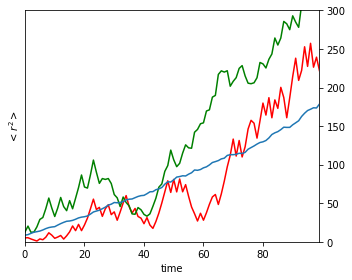

In [8]:
# generate time array to correspond to n_steps
time = np.arange(0, n_steps, 1)

fig, ax = plt.subplots()
ax.plot(time, r2_insect_time[:,0], c = 'red') # this is just looking at a single insect's r2 vs time
ax.plot(time, r2_insect_time[:,2], c = 'green') # this is just looking at a single insect's r2 vs time
ax.plot(time, avg_r2_time) # this is the average over all insects r^2
ax.set(xlim=(0, n_steps-1), ylim=(0, 3*n_steps))
ax.yaxis.tick_right()
ax.set_xlabel('time')
ax.set_ylabel('$<r^2>$')
plt.show()

## ANIMATION 

<IPython.core.display.Javascript object>


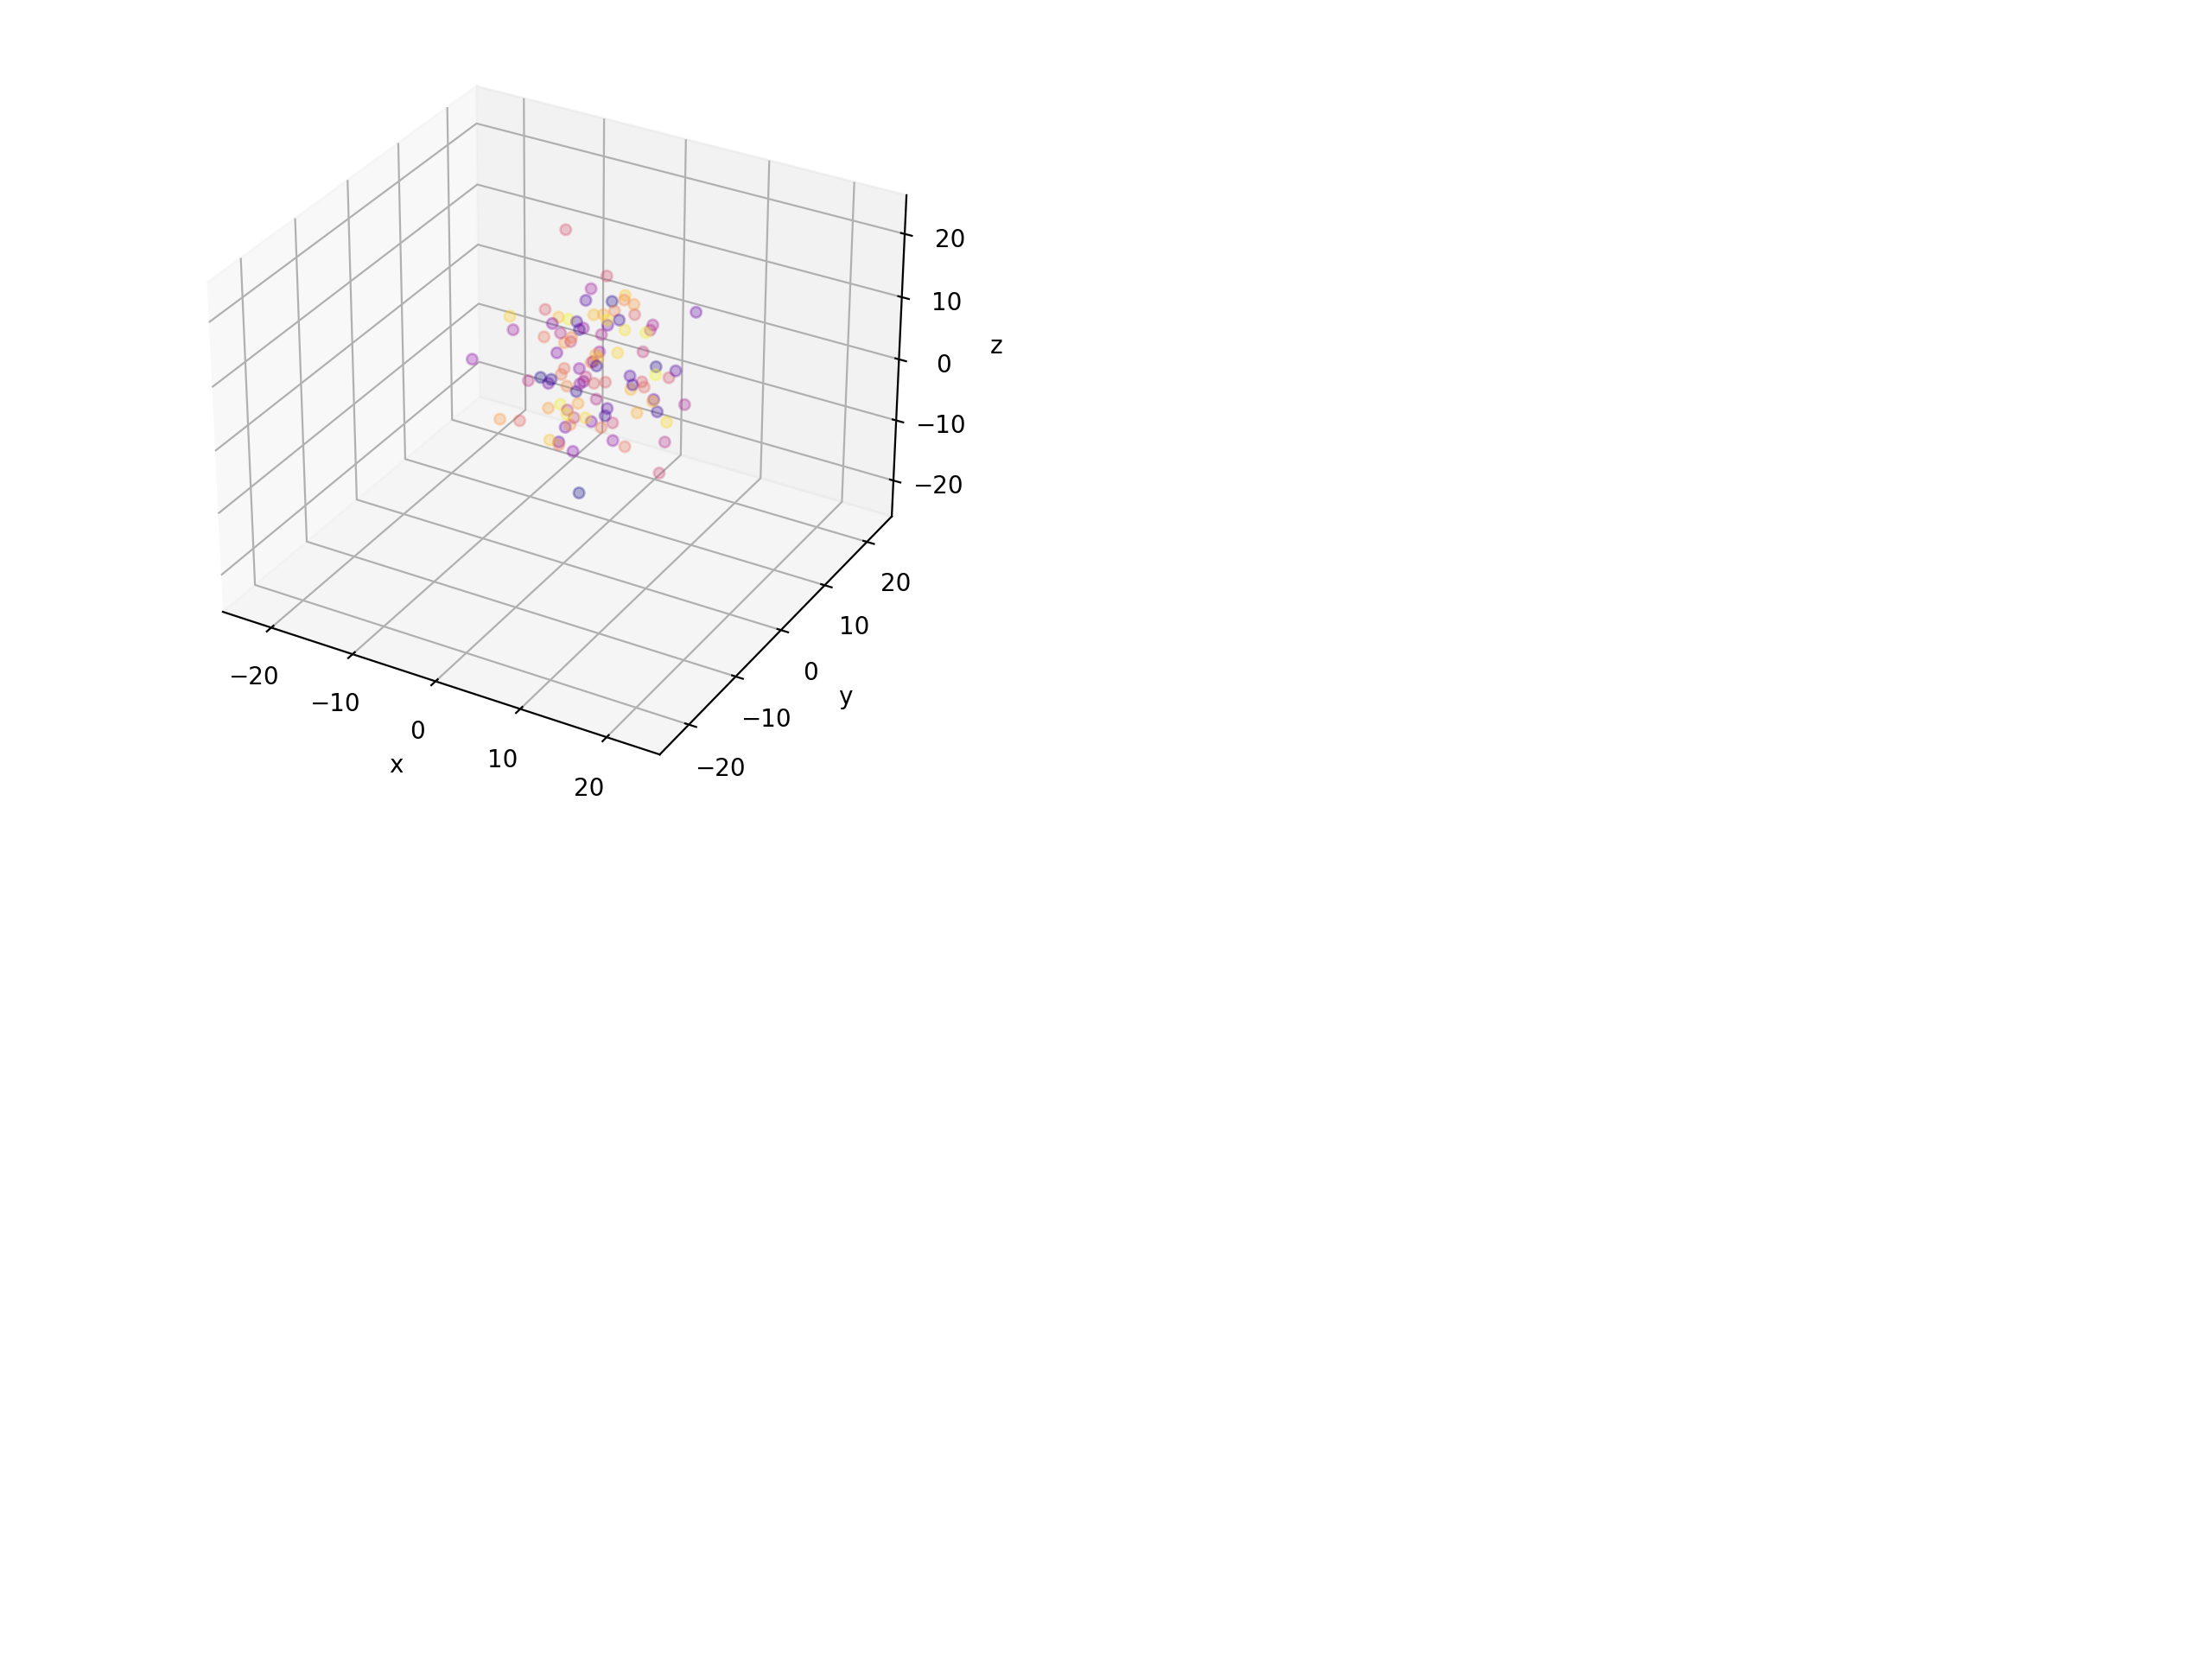

In [9]:
if animate_on:
    from matplotlib.animation import FuncAnimation
    # necessary for animation, also allows you to interact with plot/animation
    %matplotlib notebook 

    scale = n_steps/4.0 # this is roughly how far the move with both features on

    def update(i):
        ax.cla()

        ax.scatter(insects[i,:,0], insects[i,:,1], insects[i,:,2], c = colors, cmap = 'plasma', alpha=0.3)

        ax.set(xlim=(-scale, scale), ylim=(-scale, scale), zlim = (-scale, scale))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')


    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(projection='3d')

    ani = FuncAnimation(fig = fig, func = update, frames = n_steps, interval = 200)

    plt.show()